In [7]:
%matplotlib inline
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

apellido = 'CONTRERAS'
conn = psycopg2.connect(database="Test1", user="postgres", password="232686", host="localhost", port="5432")

In [8]:
gdf_comunas = gpd.read_file('COMUNA/COMUNAS_2020.shp')

gdf_comunas = gdf_comunas[ (gdf_comunas.PROVINCIA == 'Santiago') 
                          & (gdf_comunas.COMUNA != 'Lo Barnechea') 
                          | (gdf_comunas.COMUNA == 'Puente Alto')
                          | (gdf_comunas.COMUNA == 'San Bernardo')]

gdf_comunas = gdf_comunas.drop(columns=['CUT_REG', 'CUT_PROV', 'REGION', 'PROVINCIA', 'SUPERFICIE'])

gdf_comunas['centroid'] = gdf_comunas['geometry'].centroid


df_apellidos = pd.read_sql(f"SELECT \"CUT\", COUNT(*) AS TOTAL_APELLIDO FROM \"PADRON\".\"BASE_SERVEL\" WHERE (\"PROVINCIA\" = 'SANTIAGO'  OR \"COMUNA\" = 'SAN BERNARDO' OR \"COMUNA\" = 'PUENTE ALTO') AND \"NOMBRE_COMPLETO\" LIKE '%{apellido} %' GROUP BY \"CUT\"", conn)
df_comunas = pd.read_sql(f"SELECT \"CUT\", COUNT(*) AS TOTAL_COMUNA  FROM \"PADRON\".\"BASE_SERVEL\" WHERE (\"PROVINCIA\" = 'SANTIAGO'  OR \"COMUNA\" = 'SAN BERNARDO' OR \"COMUNA\" = 'PUENTE ALTO') GROUP BY \"CUT\"", conn)
total_nacional = pd.read_sql(f"SELECT COUNT(*) AS TOTAL_NACIONAL FROM \"PADRON\".\"BASE_SERVEL\" WHERE \"NOMBRE_COMPLETO\" LIKE '%{apellido} %'", conn)
total_nacional = total_nacional['total_nacional'][0]
gdf_comunas = gdf_comunas.join(df_apellidos.set_index('CUT'), on='CUT_COM')
gdf_comunas = gdf_comunas.join(df_comunas.set_index('CUT'), on='CUT_COM')

gdf_comunas['total_apellido'] = gdf_comunas['total_apellido'].fillna(0)
gdf_comunas['total_comuna'] = gdf_comunas['total_comuna'].fillna(0)
gdf_comunas['distribucion_comuna'] = gdf_comunas['total_apellido']/gdf_comunas['total_comuna']*100

total = gdf_comunas['total_apellido'].sum()


C:\Users\panch\AppData\Local\Temp/ipykernel_7236/1155754167.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_comunas['centroid'] = gdf_comunas['geometry'].centroid


C:\Users\panch\AppData\Local\Temp/ipykernel_7236/2275160465.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.set_yticklabels(['{0:.2f}%'.format(ytick) for ytick in yticks])


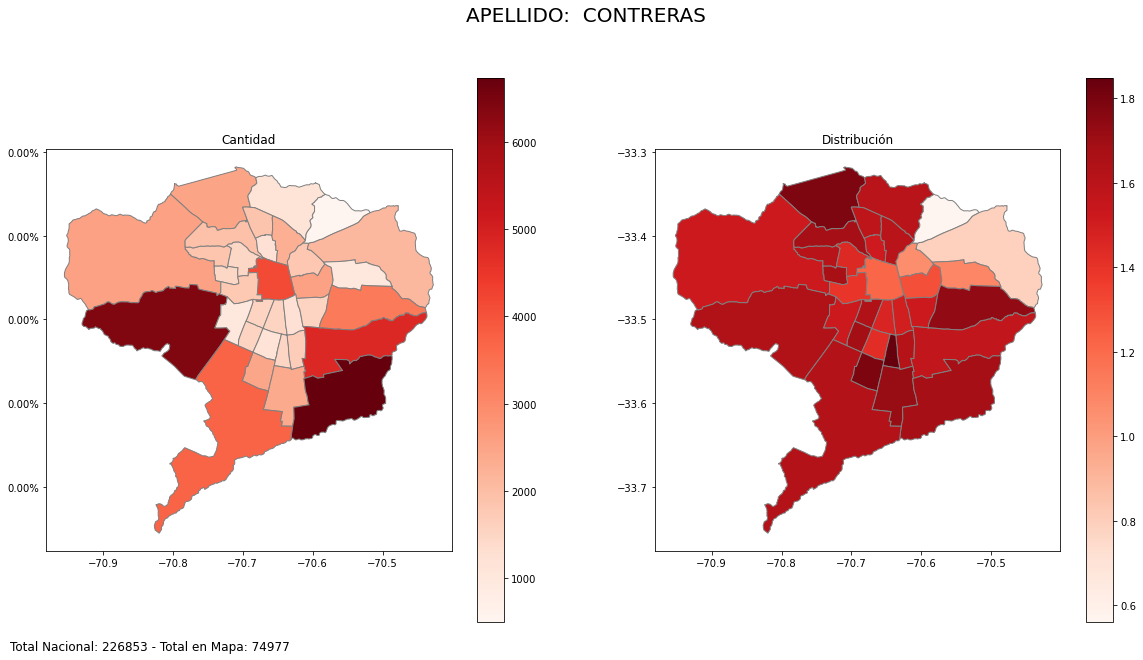

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,18))

gdf_comunas.plot(ax=ax1, column='total_apellido', cmap='Reds', edgecolor='grey', legend=True)
gdf_comunas.plot(ax=ax2, column='distribucion_comuna', cmap='Reds', edgecolor='grey', legend=True)

ax1.set_title("Cantidad")
ax2.set_title("Distribución")

fig.suptitle(f'APELLIDO:  {apellido}', fontsize= 20)
fig.set_size_inches(20, 10)


colorbar = ax2.get_figure().get_axes()[0]

yticks = np.interp(colorbar.get_yticks(), [0,1], [0, 1])

colorbar.set_yticklabels(['{0:.2f}%'.format(ytick) for ytick in yticks])

plt.figtext(0.1,0.1, f'Total Nacional: {total_nacional} - Total en Mapa: {total}', fontsize=12, va="top", ha="left")

plt.show()



